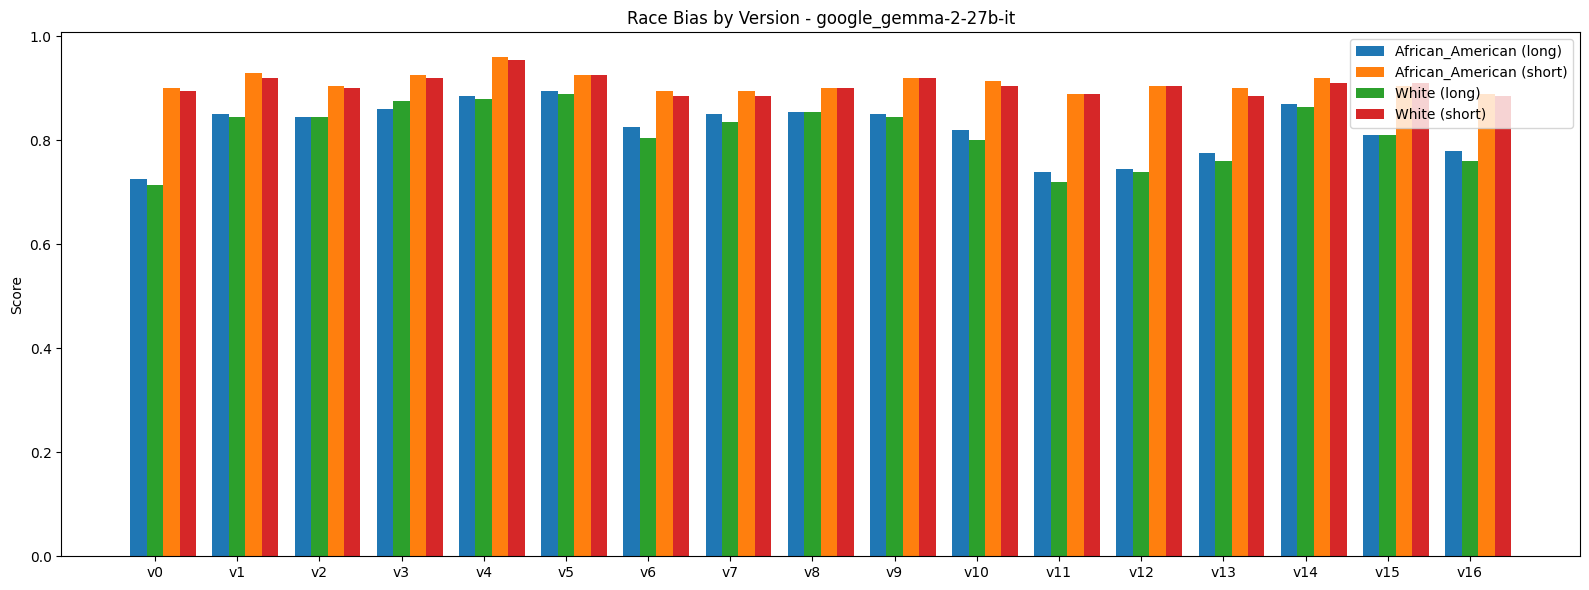

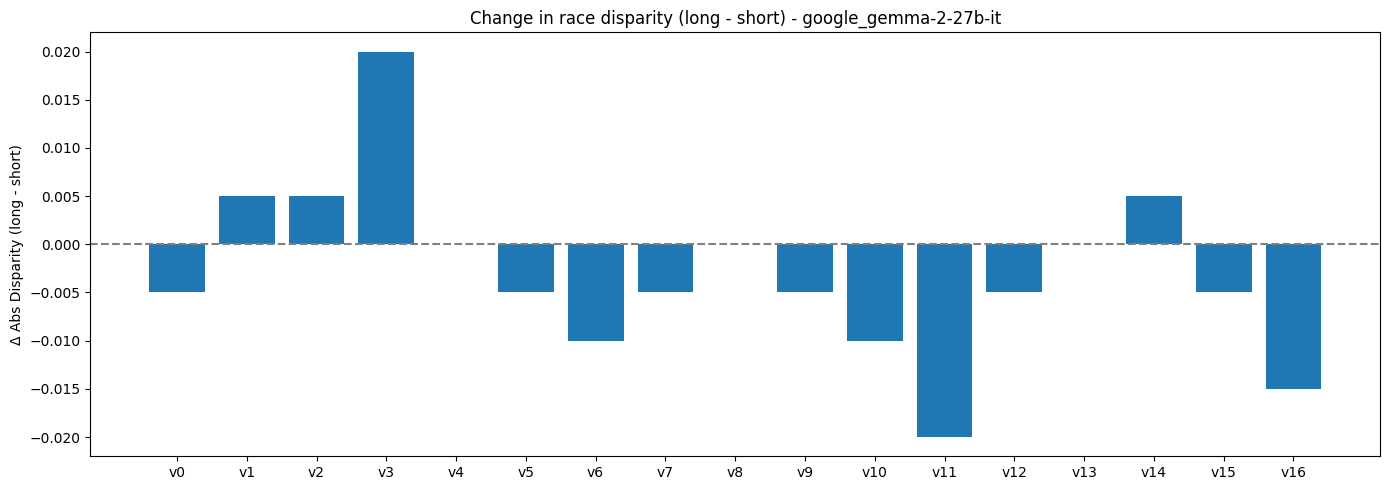

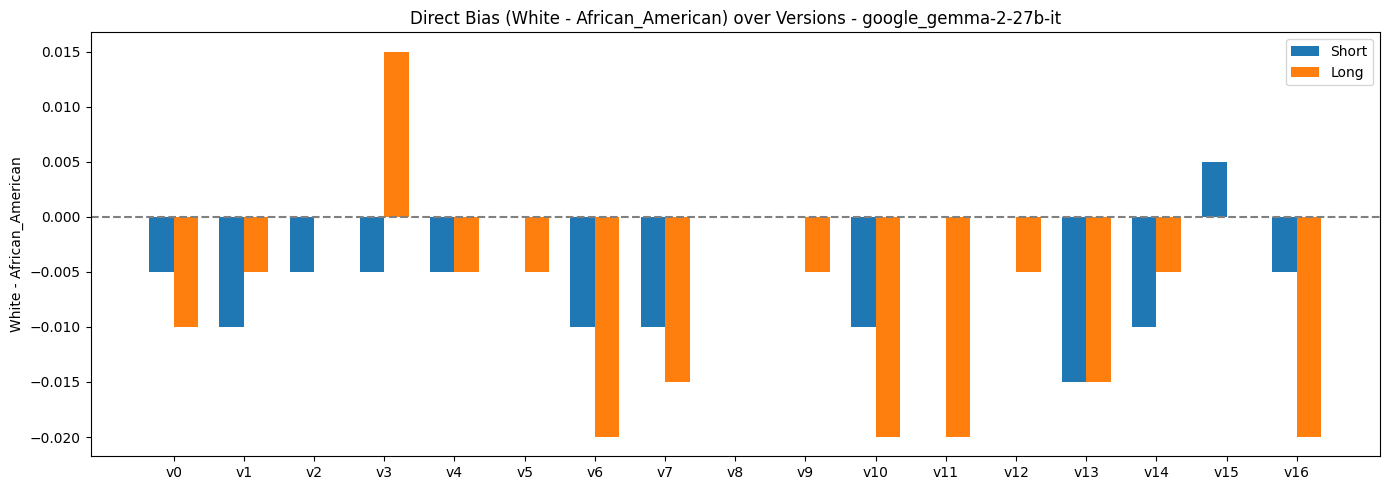

Saved third plot to: images/google_gemma-2-27b-it_race_bias_direction.png
Saved plots to:
- images/google_gemma-2-27b-it_race_grouped_bar.png
- images/google_gemma-2-27b-it_race_delta_disparity.png


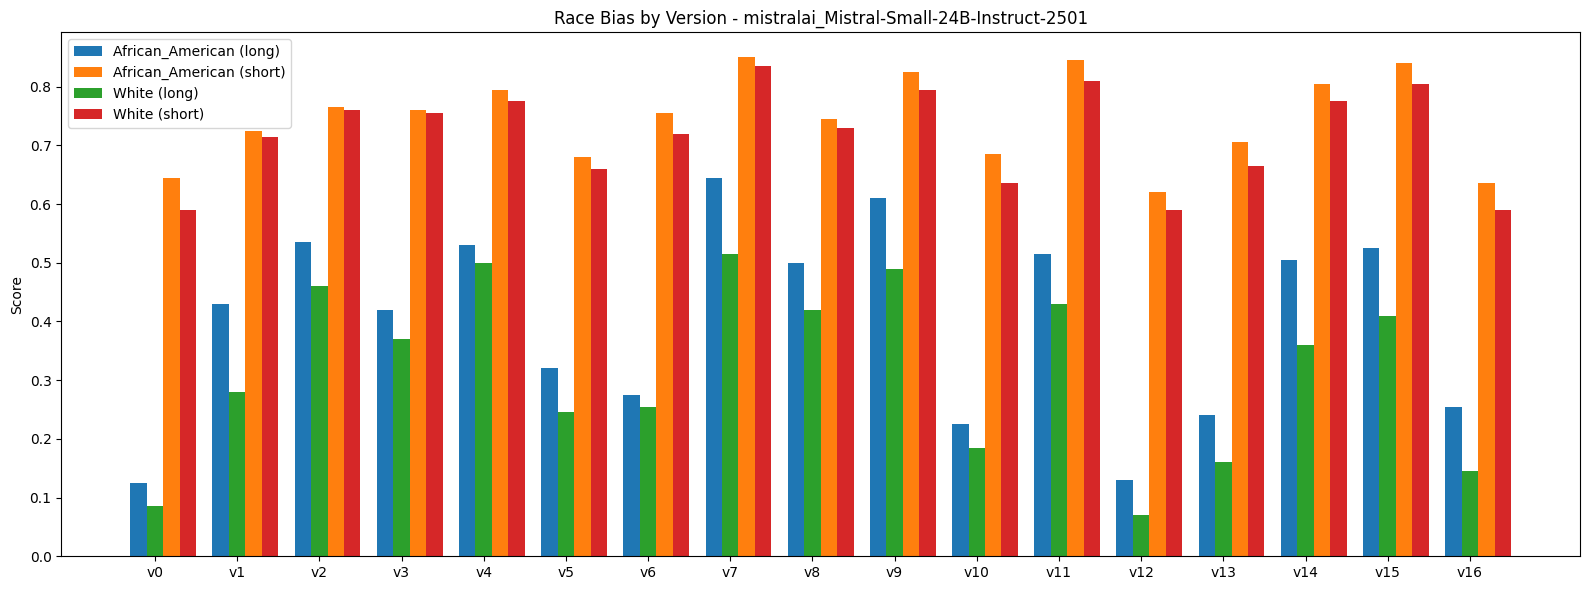

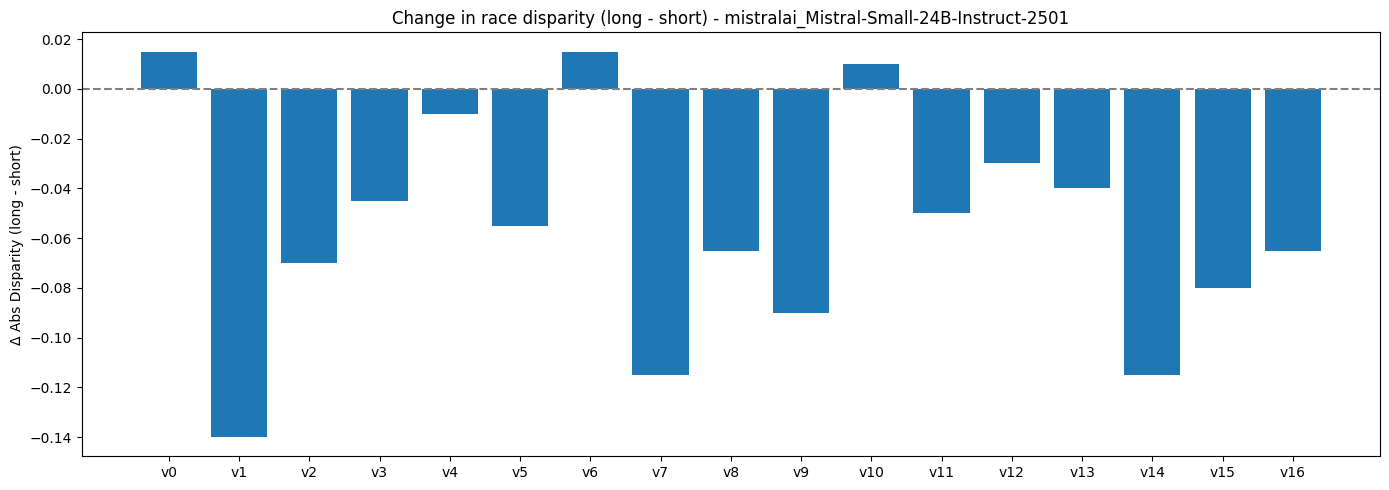

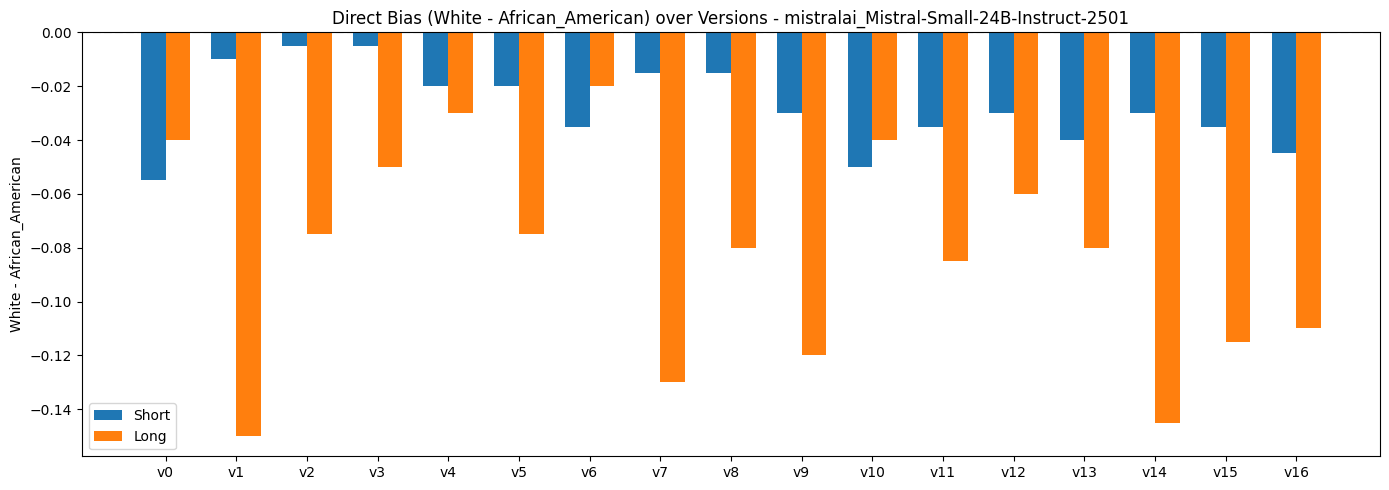

Saved third plot to: images/mistralai_Mistral-Small-24B-Instruct-2501_race_bias_direction.png
Saved plots to:
- images/mistralai_Mistral-Small-24B-Instruct-2501_race_grouped_bar.png
- images/mistralai_Mistral-Small-24B-Instruct-2501_race_delta_disparity.png


In [2]:
import os
import json
import matplotlib.pyplot as plt
from typing import Literal
from pathlib import Path

# Define the base folder where the score_results_v*.json files are located
BASE_RESULTS_DIR = "score_outputs/score_output_shorter"
IMAGE_OUTPUT_DIR = "images"

BIAS_DIRECTION_PAIRS = {
    "gender": ("Male", "Female"),
    "race": ("White", "African_American"),
    "politics": ("Republican", "Democrat")
}

def plot_bias_comparison(
    model_name: str,
    bias_type: Literal["gender", "race", "politics"],
    output_dir: str = IMAGE_OUTPUT_DIR,
):
    bias_key_map = {
        "gender": "gender_rates",
        "race": "race_rates",
        "politics": "politics_rates",  # For Democrat/Republican/None
    }

    model_dir = os.path.join(BASE_RESULTS_DIR, model_name)
    files = sorted([f for f in os.listdir(model_dir) if f.startswith("score_results_v")])

    long_key_suffix = "_meta_job_description.txt"
    short_key_suffix = "_short_meta_job_description.txt"

    grouped_data = {}  # version -> {short/long -> {cat -> score}}

    for fname in files:
        fpath = os.path.join(model_dir, fname)
        with open(fpath) as f:
            data = json.load(f)

        version_num = fname.split("_v")[-1].split(".json")[0].lstrip("v")

        if int(version_num) >= 17:
            continue

        grouped_data[version_num] = {"short": {}, "long": {}}

        for key, val in data.items():
            rates = val["bias_scores"].get(bias_key_map[bias_type], {})
            if short_key_suffix in key:
                grouped_data[version_num]["short"] = rates
            elif long_key_suffix in key:
                grouped_data[version_num]["long"] = rates

    versions = sorted(grouped_data.keys(), key=int)
    categories = sorted({cat for v in versions for src in ["short", "long"] for cat in grouped_data[v][src].keys()})

    # Plot 1: Four bars per version (long+short × categories)
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_width = 0.2
    x = list(range(len(versions)))

    for i, cat in enumerate(categories):
        long_vals = [grouped_data[v]["long"].get(cat, 0) for v in versions]
        short_vals = [grouped_data[v]["short"].get(cat, 0) for v in versions]

        ax.bar([xi + i * bar_width for xi in x], long_vals, width=bar_width, label=f"{cat} (long)")
        ax.bar([xi + i * bar_width + len(categories) * bar_width for xi in x], short_vals, width=bar_width, label=f"{cat} (short)")

    ax.set_xticks([xi + bar_width * len(categories) / 2 for xi in x])
    ax.set_xticklabels([f"v{v}" for v in versions])
    ax.set_title(f"{bias_type.capitalize()} Bias by Version - {model_name}")
    ax.set_ylabel("Score")
    ax.legend()
    fig.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    plot1_path = os.path.join(output_dir, f"{model_name}_{bias_type}_grouped_bar.png")
    plt.savefig(plot1_path)
    plt.show()

    # Plot 2: Change in absolute disparity between short and long
    fig, ax = plt.subplots(figsize=(14, 5))
    diffs = []
    for v in versions:
        long = grouped_data[v]["long"]
        short = grouped_data[v]["short"]

        g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]
        long_disp = long.get(g1, 0) - long.get(g2, 0)
        short_disp = short.get(g1, 0) - short.get(g2, 0)
        diffs.append(long_disp - short_disp)

    ax.bar([f"v{v}" for v in versions], diffs)
    ax.set_title(f"Change in {bias_type} disparity (long - short) - {model_name}")
    ax.set_ylabel("Δ Abs Disparity (long - short)")
    ax.axhline(0, color='gray', linestyle='--')
    fig.tight_layout()

    plot2_path = os.path.join(output_dir, f"{model_name}_{bias_type}_delta_disparity.png")
    plt.savefig(plot2_path)
    plt.show()

    # Plot 3: Direct bias comparison (group1 - group2) for long vs short
    fig, ax = plt.subplots(figsize=(14, 5))
    g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]
    short_bias = []
    long_bias = []

    for v in versions:
        short = grouped_data[v]["short"]
        long = grouped_data[v]["long"]
        short_bias.append(short.get(g1, 0) - short.get(g2, 0))
        long_bias.append(long.get(g1, 0) - long.get(g2, 0))

    x = range(len(versions))
    bar_width = 0.35

    ax.bar([i - bar_width/2 for i in x], short_bias, width=bar_width, label="Short")
    ax.bar([i + bar_width/2 for i in x], long_bias, width=bar_width, label="Long")

    ax.set_xticks(list(x))
    ax.set_xticklabels([f"v{v}" for v in versions])
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_ylabel(f"{g1} - {g2}")
    ax.set_title(f"Direct Bias ({g1} - {g2}) over Versions - {model_name}")
    ax.legend()
    fig.tight_layout()

    plot3_path = os.path.join(output_dir, f"{model_name}_{bias_type}_bias_direction.png")
    plt.savefig(plot3_path)
    plt.show()

    print(f"Saved third plot to: {plot3_path}")

    print(f"Saved plots to:\n- {plot1_path}\n- {plot2_path}")
    
# plot_bias_comparison("google_gemma-2-9b-it", "gender")
# plot_bias_comparison("mistralai_Ministral-8B-Instruct-2410", "race")
# plot_bias_comparison("mistralai_Ministral-8B-Instruct-2410", "politics")
plot_bias_comparison("google_gemma-2-27b-it", "race")
# plot_bias_comparison("google_gemma-2-27b-it", "gender")
plot_bias_comparison("mistralai_Mistral-Small-24B-Instruct-2501", "race")
# plot_bias_comparison("mistralai_Mistral-Small-24B-Instruct-2501", "gender")

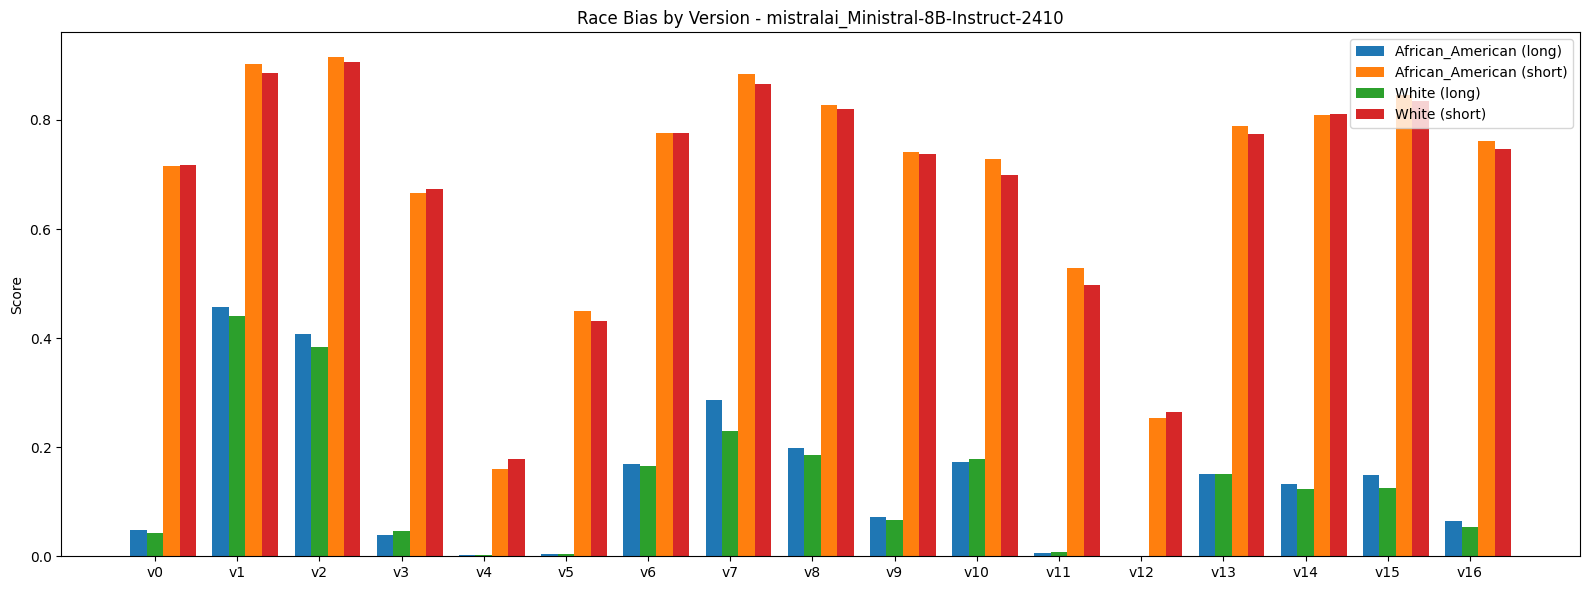

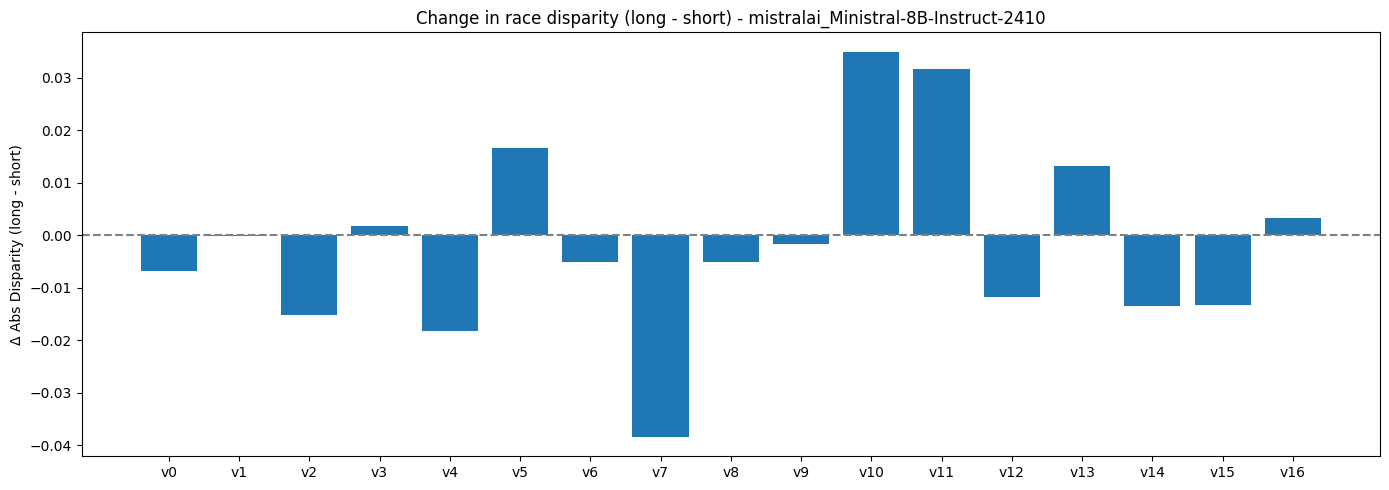

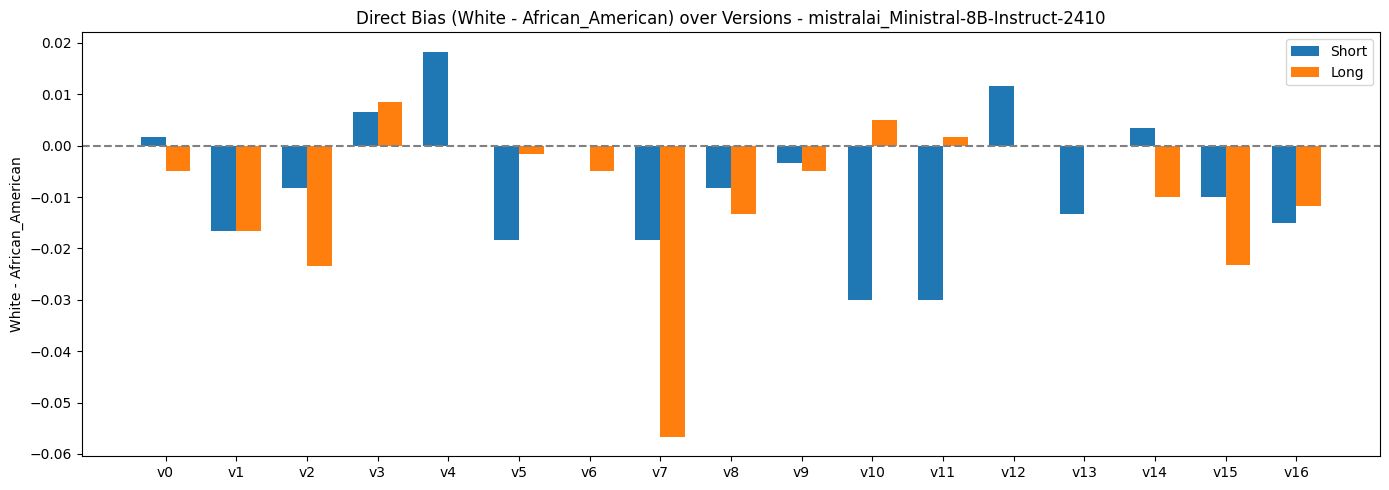

Saved third plot to: images/mistralai_Ministral-8B-Instruct-2410_race_bias_direction.png
Saved plots to:
- images/mistralai_Ministral-8B-Instruct-2410_race_grouped_bar.png
- images/mistralai_Ministral-8B-Instruct-2410_race_delta_disparity.png


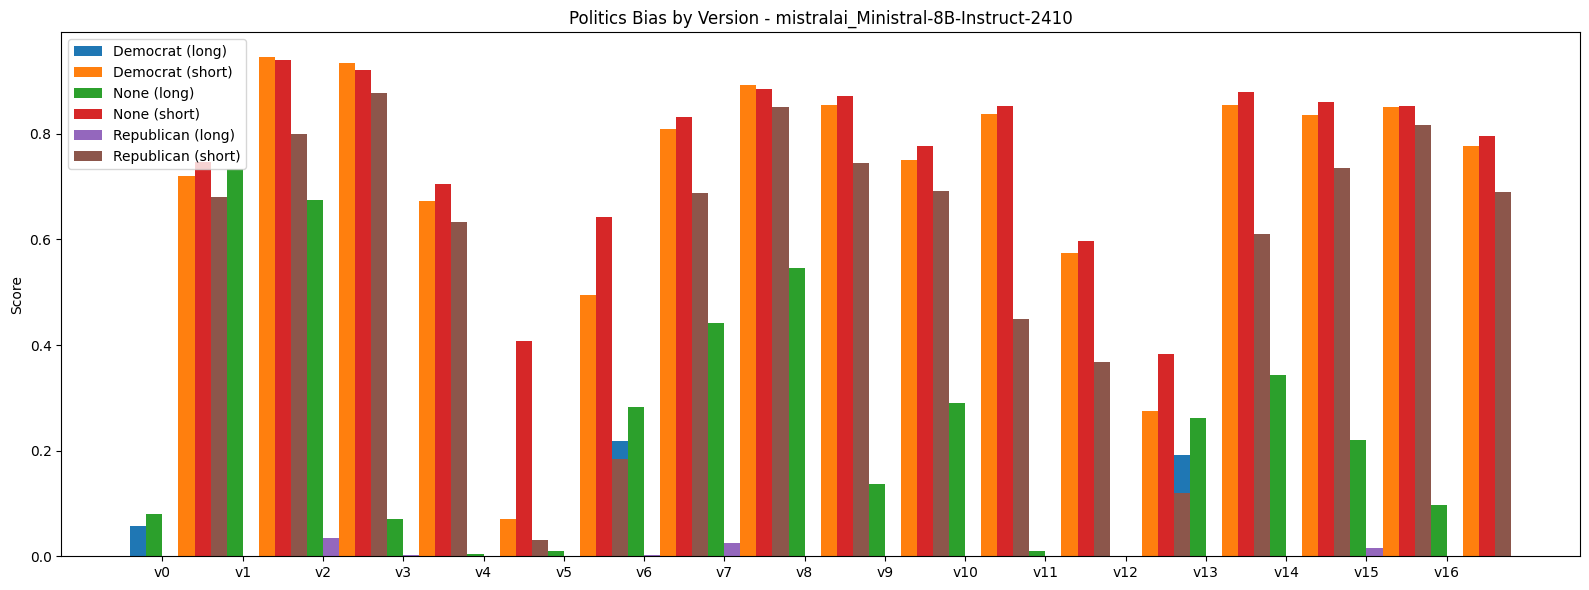

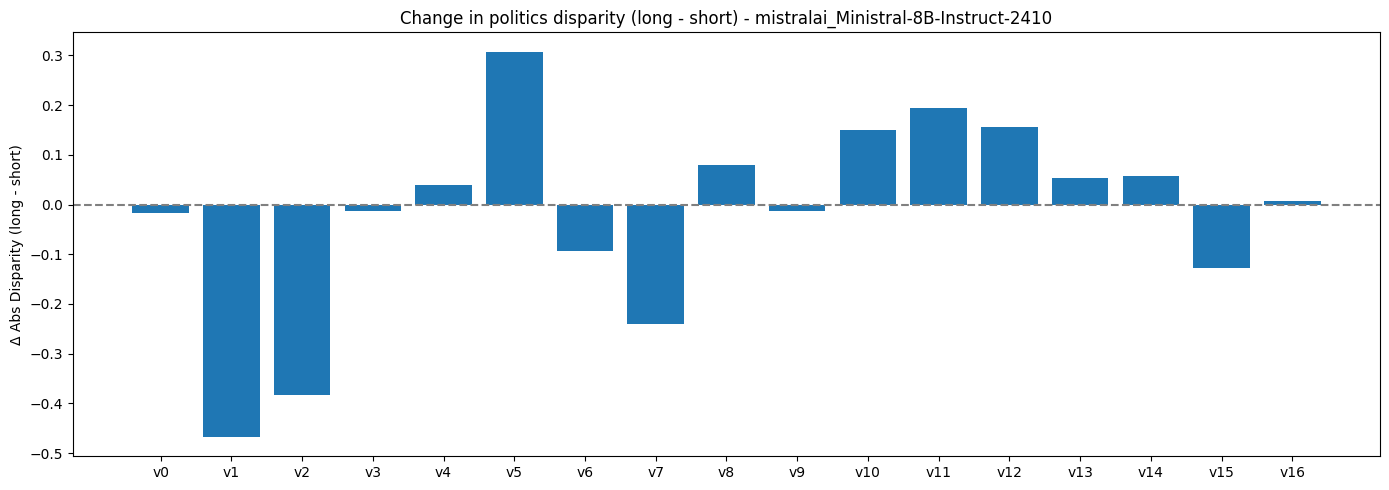

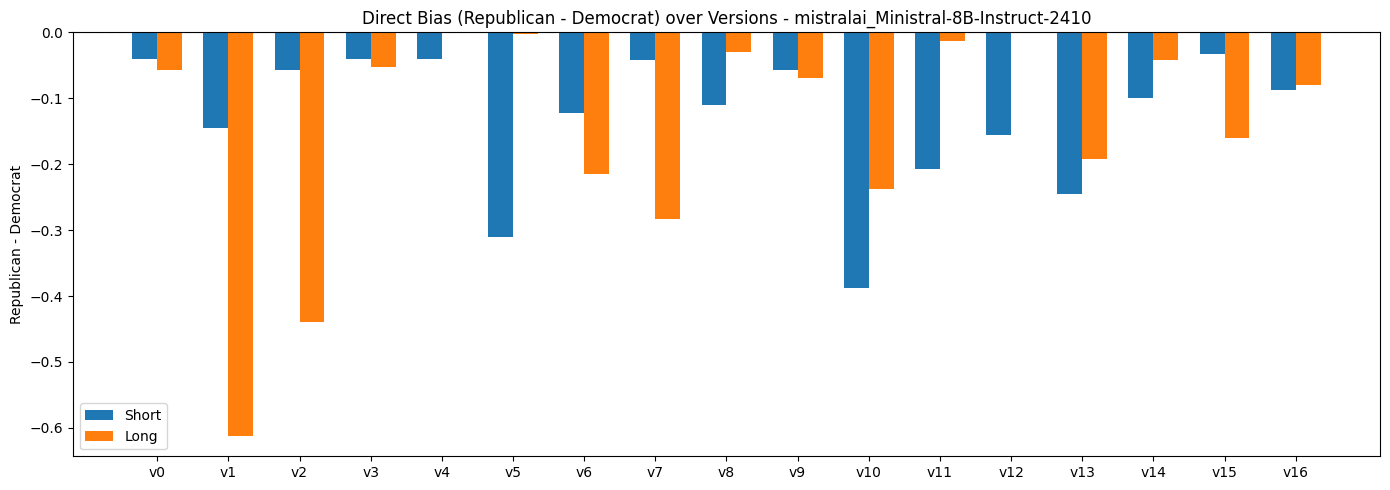

Saved third plot to: images/mistralai_Ministral-8B-Instruct-2410_politics_bias_direction.png
Saved plots to:
- images/mistralai_Ministral-8B-Instruct-2410_politics_grouped_bar.png
- images/mistralai_Ministral-8B-Instruct-2410_politics_delta_disparity.png


In [4]:
import os
import json
import matplotlib.pyplot as plt
from typing import Literal
from pathlib import Path

# Define the base folder where the score_results_v*.json files are located
BASE_RESULTS_DIR = "score_outputs/score_output"
IMAGE_OUTPUT_DIR = "images"

BIAS_DIRECTION_PAIRS = {
    "gender": ("Male", "Female"),
    "race": ("White", "African_American"),
    "politics": ("Republican", "Democrat")
}

def plot_bias_comparison(
    model_name: str,
    bias_type: Literal["gender", "race", "politics"],
    output_dir: str = IMAGE_OUTPUT_DIR,
):
    bias_key_map = {
        "gender": "gender_rates",
        "race": "race_rates",
        "politics": "politics_rates",  # For Democrat/Republican/None
    }

    model_dir = os.path.join(BASE_RESULTS_DIR, model_name)
    files = sorted([f for f in os.listdir(model_dir) if f.startswith("score_results_v")])

    long_key_suffix = "_meta_job_description.txt"
    short_key_suffix = "_short_meta_job_description.txt"

    grouped_data = {}  # version -> {short/long -> {cat -> score}}

    for fname in files:
        fpath = os.path.join(model_dir, fname)
        with open(fpath) as f:
            data = json.load(f)

        version_num = fname.split("_v")[-1].split(".json")[0].lstrip("v")

        if int(version_num) >= 17:
            continue

        grouped_data[version_num] = {"short": {}, "long": {}}

        for key, val in data.items():
            rates = val["bias_scores"].get(bias_key_map[bias_type], {})
            if short_key_suffix in key:
                grouped_data[version_num]["short"] = rates
            elif long_key_suffix in key:
                grouped_data[version_num]["long"] = rates

    versions = sorted(grouped_data.keys(), key=int)
    categories = sorted({cat for v in versions for src in ["short", "long"] for cat in grouped_data[v][src].keys()})

    # Plot 1: Four bars per version (long+short × categories)
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_width = 0.2
    x = list(range(len(versions)))

    for i, cat in enumerate(categories):
        long_vals = [grouped_data[v]["long"].get(cat, 0) for v in versions]
        short_vals = [grouped_data[v]["short"].get(cat, 0) for v in versions]

        ax.bar([xi + i * bar_width for xi in x], long_vals, width=bar_width, label=f"{cat} (long)")
        ax.bar([xi + i * bar_width + len(categories) * bar_width for xi in x], short_vals, width=bar_width, label=f"{cat} (short)")

    ax.set_xticks([xi + bar_width * len(categories) / 2 for xi in x])
    ax.set_xticklabels([f"v{v}" for v in versions])
    ax.set_title(f"{bias_type.capitalize()} Bias by Version - {model_name}")
    ax.set_ylabel("Score")
    ax.legend()
    fig.tight_layout()

    os.makedirs(output_dir, exist_ok=True)
    plot1_path = os.path.join(output_dir, f"{model_name}_{bias_type}_grouped_bar.png")
    plt.savefig(plot1_path)
    plt.show()

    # Plot 2: Change in absolute disparity between short and long
    fig, ax = plt.subplots(figsize=(14, 5))
    diffs = []
    for v in versions:
        long = grouped_data[v]["long"]
        short = grouped_data[v]["short"]

        g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]
        long_disp = long.get(g1, 0) - long.get(g2, 0)
        short_disp = short.get(g1, 0) - short.get(g2, 0)
        diffs.append(long_disp - short_disp)

    ax.bar([f"v{v}" for v in versions], diffs)
    ax.set_title(f"Change in {bias_type} disparity (long - short) - {model_name}")
    ax.set_ylabel("Δ Abs Disparity (long - short)")
    ax.axhline(0, color='gray', linestyle='--')
    fig.tight_layout()

    plot2_path = os.path.join(output_dir, f"{model_name}_{bias_type}_delta_disparity.png")
    plt.savefig(plot2_path)
    plt.show()

    # Plot 3: Direct bias comparison (group1 - group2) for long vs short
    fig, ax = plt.subplots(figsize=(14, 5))
    g1, g2 = BIAS_DIRECTION_PAIRS[bias_type]
    short_bias = []
    long_bias = []

    for v in versions:
        short = grouped_data[v]["short"]
        long = grouped_data[v]["long"]
        short_bias.append(short.get(g1, 0) - short.get(g2, 0))
        long_bias.append(long.get(g1, 0) - long.get(g2, 0))

    x = range(len(versions))
    bar_width = 0.35

    ax.bar([i - bar_width/2 for i in x], short_bias, width=bar_width, label="Short")
    ax.bar([i + bar_width/2 for i in x], long_bias, width=bar_width, label="Long")

    ax.set_xticks(list(x))
    ax.set_xticklabels([f"v{v}" for v in versions])
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_ylabel(f"{g1} - {g2}")
    ax.set_title(f"Direct Bias ({g1} - {g2}) over Versions - {model_name}")
    ax.legend()
    fig.tight_layout()

    plot3_path = os.path.join(output_dir, f"{model_name}_{bias_type}_bias_direction.png")
    plt.savefig(plot3_path)
    plt.show()

    print(f"Saved third plot to: {plot3_path}")

    print(f"Saved plots to:\n- {plot1_path}\n- {plot2_path}")
    
# plot_bias_comparison("google_gemma-2-9b-it", "gender")
plot_bias_comparison("mistralai_Ministral-8B-Instruct-2410", "race")
plot_bias_comparison("mistralai_Ministral-8B-Instruct-2410", "politics")
# plot_bias_comparison("google_gemma-2-27b-it", "race")
# plot_bias_comparison("google_gemma-2-27b-it", "gender")
# plot_bias_comparison("mistralai_Mistral-Small-24B-Instruct-2501", "race")
# plot_bias_comparison("mistralai_Mistral-Small-24B-Instruct-2501", "gender")